In [1]:
# Data manipulation imports
import numpy as np
import pandas as pd

# Visualization imports
import matplotlib.pyplot as plt
import plotly.express as px

# Modeling imports
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

In [7]:
# Read the data as a DataFrame
df = pd.read_csv("bank.csv")

# Preview the DataFrame
df

,age,job,marital,education,default,balance,housing,loan,contact,month,duration,poutcome,deposit
0,NaN,admin.,married,secondary,no,NaN,yes,no,unknown,may,1042.0,unknown,yes
1,56.0,admin.,married,secondary,no,45.0,no,no,unknown,may,1467.0,unknown,yes
2,41.0,technician,married,secondary,no,1270.0,yes,no,unknown,may,1389.0,unknown,yes
3,55.0,services,married,secondary,no,NaN,yes,no,unknown,may,NaN,unknown,yes
4,54.0,admin.,married,tertiary,no,184.0,no,no,unknown,may,673.0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33.0,blue-collar,single,primary,no,1.0,yes,no,cellular,apr,257.0,unknown,no
11158,39.0,services,married,secondary,no,733.0,no,no,unknown,jun,83.0,unknown,no
11159,32.0,technician,single,secondary,no,29.0,no,no,cellular,aug,156.0,unknown,no
11160,43.0,technician,NaN,NaN,no,NaN,no,yes,cellular,may,NaN,failure,no


In [8]:
# Return a summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        8595 non-null   float64
 1   job        11162 non-null  object 
 2   marital    10381 non-null  object 
 3   education  10716 non-null  object 
 4   default    11162 non-null  object 
 5   balance    8343 non-null   float64
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   month      11162 non-null  object 
 10  duration   9488 non-null   float64
 11  poutcome   11162 non-null  object 
 12  deposit    11162 non-null  object 
dtypes: float64(3), object(10)
memory usage: 1.1+ MB


In [9]:
# Sum all missing values across rows
df.isna().sum().sort_values(ascending=False)

balance      2819
age          2567
duration     1674
marital       781
education     446
job             0
default         0
housing         0
loan            0
contact         0
month           0
poutcome        0
deposit         0
dtype: int64

In [10]:
# Get the value counts of the deposit column
df["deposit"].value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

Categorical variables
Let's loop through our categorical variables and get an understanding of the different values they can take.

This can also help us understand if there are any variables that need to be reduced in preparation for one-hot-encoding.

In [11]:
# Define our categorical variables
categorical_variables = df.select_dtypes(include=["object"]).columns.tolist()
categorical_variables.remove("deposit")

# Print the value counts of the categorical columns
for var in categorical_variables:
    value_counts = df[var].value_counts(ascending=True)
    fig = px.bar(value_counts,
                 x=var,
                 y=value_counts.index,
                 title=var
                )
    
    fig.show()

In [12]:
# Define our numeric variables
numeric_variables = df.select_dtypes(include=["float64"]).columns.tolist()

# Create a histogram for each variable
for var in numeric_variables:
    fig = px.histogram(df,
                       x=var,
                       title=var
                      )
    fig.show()

In [13]:
# Define X and y
X = df[numeric_variables + categorical_variables]
y = df["deposit"]

# Split our data into train and testing subsets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=1
)

### Preprocessing the data
Categorical data
Some of our categorical variables had missing values. We could consider dropping them, but let's try filling these missing values using a SimpleImputer().

In [14]:
# Initialize the imputer and set the strategy to 'most_frequent'
imp = SimpleImputer(strategy="most_frequent")

# Fit and transform the column with the missing data
education_filled = imp.fit_transform(X_train[["education"]])

# Create a new DataFrame of the data for comparison purposes
pd.concat(
    [pd.DataFrame(education_filled), X_train[["education"]]], axis=1, ignore_index=True
)

,0,1
0,primary,secondary
1,secondary,secondary
2,secondary,secondary
3,secondary,secondary
4,tertiary,NaN
...,...,...
8444,NaN,primary
9394,NaN,tertiary
10989,NaN,unknown
7813,NaN,secondary


In [16]:

### We will also perform one-hot encoding on our categorical data.

# Initialize the encoder
ohencoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Fit and transform the marital column
marital_encoded = ohencoder.fit_transform(X_train[["marital"]])

# View the resulting columns
pd.DataFrame(marital_encoded, columns=ohencoder.get_feature_names_out())

,marital_divorced,marital_married,marital_single,marital_nan
0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
7808,0.0,1.0,0.0,0.0
7809,0.0,1.0,0.0,0.0
7810,0.0,1.0,0.0,0.0
7811,0.0,0.0,1.0,0.0


In [17]:
# Initialize the encoder
ohencoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Fit and transform the marital column
marital_encoded = ohencoder.fit_transform(X_train[["marital"]])

# View the resulting columns
pd.DataFrame(marital_encoded, columns=ohencoder.get_feature_names_out())

,marital_divorced,marital_married,marital_single,marital_nan
0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
7808,0.0,1.0,0.0,0.0
7809,0.0,1.0,0.0,0.0
7810,0.0,1.0,0.0,0.0
7811,0.0,0.0,1.0,0.0



Transforming the numeric data
Our numeric data also has missing values, which we will want to correct for. We will also want to standardize our data so that all features are centered around zero and have a variance of one.

Let's see an example of this below using StandardScaler().

In [18]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the with the standard scaler
balance_transformed = scaler.fit_transform(X_train[["balance"]])

# Create a new DataFrame of the data for comparison purposes
px.histogram(balance_transformed)

### Pipeline
We can now create two pipelines to transform our categorical and numerical data. We construct them separately using Pipeline().

In [19]:
# Define pipelines for our categorical and numeric variables
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
        ("ohencoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]
)

In [21]:
## We then combine these pipelines into a ColumnTransformer(), which we add to a final pipeline with the classification model we want to use.


# Initialize a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_variables),
        ("cat", categorical_transformer, categorical_variables)
    ]
)
# Add the transformer to a pipeline with our model
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier())]
)


### Training our model
We train our model by fitting the pipeline to the training data and then creating our predictions with the test data.

In [22]:
# Train the classifier on the train set
clf.fit(X_train, y_train)

# Predict the outcomes on the test set
y_pred = clf.predict(X_test)


### Evaluating our model

Finally, we calculate the accuracy of our model, as well as print a confusion matrix.

In [24]:
# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7805315019408778


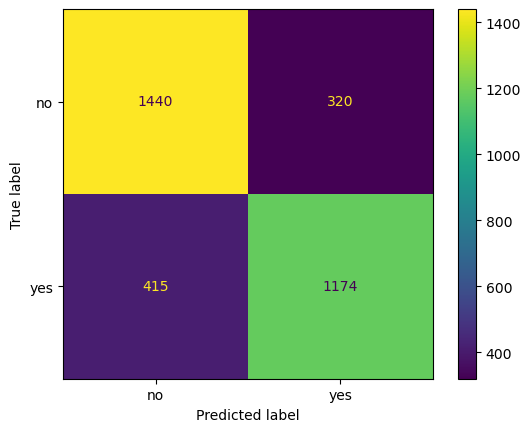

In [25]:
# Create and siplay the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()